In [1]:
# load and clean-up data
from numpy import nan
from numpy import isnan
from pandas import read_csv
from pandas import to_numeric
 
# fill missing values with a value at the same time one day ago
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

In [2]:
dataset = read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')
# fill missing
fill_missing(dataset.values)
# add a column for for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
# save updated dataset
dataset.to_csv('household_power_consumption.csv')

In [3]:
# resample minute data to total for each day
from pandas import read_csv
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv('household_power_consumption_days.csv')

(1442, 8)
            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.0   
2006-12-20            9313

In [4]:
!dir

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 309E-5A99

 C:\Users\yckim\workspace\yckTS\TS\4 디렉터리

2020-05-23  오후 12:24    <DIR>          .
2020-05-23  오후 12:24    <DIR>          ..
2020-05-06  오후 03:32    <DIR>          .ipynb_checkpoints
2020-05-23  오후 12:24            12,211 4_TS_CNN_LSTM.ipynb
2020-05-06  오후 03:32            68,019 4_TS_simple_CNN.ipynb
2020-04-11  오전 06:58            73,343 AAPL1216.csv
2020-05-23  오후 12:22       132,841,235 household_power_consumption.csv
2012-10-12  오후 01:38       132,960,755 household_power_consumption.txt
2020-05-23  오후 12:24           176,667 household_power_consumption_days.csv
2020-04-11  오전 09:45             6,689 TS_cnn_lstm.py
2020-04-28  오후 08:50             5,296 TS_simple_cnn.py
               8개 파일         266,144,215 바이트
               3개 디렉터리  241,175,945,216 바이트 남음


## Import Packages

In [5]:
# univariate multi-step cnn-lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

Using TensorFlow backend.


In [6]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]

    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        
        # calculate rmse
        rmse = sqrt(mse)
        
        # store
        scores.append(rmse)
        
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores
 
    
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

    
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0

    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
            
        # move along one time step
        in_start += 1
    return array(X), array(y)
 

# train the model
def build_model(train, n_input):

    # prepare data
    train_x, train_y = to_supervised(train, n_input)

    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model



# make a forecast
def forecast(model, history, n_input):
    
    # flatten data --> 주간별로 나뉘어진 데이터구조를 remove so that we end up with eight parallel time series.
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat
 

# evaluate a single model
def evaluate_model(train, test, n_input):
    
    # fit model
    model = build_model(train, n_input)
    
    # history is a list of weekly data
    history = [x for x in train]
    
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        
        # store the predictions
        predictions.append(yhat_sequence)
        
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores
 

In [7]:
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)

In [8]:
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)

In [9]:
# summarize scores
summarize_scores('lstm', score, scores)

lstm: [390.363] 388.0, 395.3, 365.6, 376.8, 405.6, 369.5, 428.0


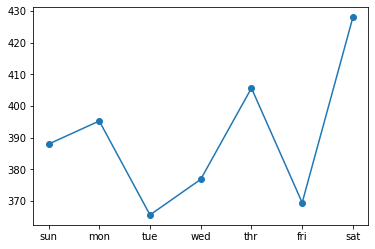

In [10]:
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()